In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import GaussianBlur

from src import dino


class ACESModel(nn.Module):
    W = 0.9
    A = 1
    B = 1
    C = 1
    D = 1
    SCALE_NORMALIZED = True
    KEY = 0.18
    
    def __init__(self):
        super(ACESModel, self).__init__()
        # a, b, c, d, e
        self.weights = nn.Parameter(torch.Tensor([2.51, 0.03, 2.43, 0.59, 0.14]))

    def forward(self, x):
        # Apply ACES tone mapper
        x = (self.KEY / (torch.mean(x**2)**(1/2))) * x
        assert_no_nans(x)
        a, b, c, d, e = self.weights
        tonemapped_x = torch.squeeze((x * (a*x + b)) / (x * (c*x + d) + e))
        # Clip results to (0, 1)
        zeros = torch.zeros(tonemapped_x.size()).to(x.device)
        tonemapped_x = torch.maximum(tonemapped_x, zeros)
        ones = torch.full(tonemapped_x.size(), 1).to(x.device)
        tonemapped_x = torch.minimum(tonemapped_x, ones)
        # Compute brightness response
        X, Y, Z = dino.torch.rgb_to_xyz(tonemapped_x)
        L, _, _ = dino.xyz_to_lxy(X, Y, Z)
        brightness_response = dino.torch.dn_brightness_model(
            L,
            w=self.W,
            a=self.A,
            b=self.B,
            c=self.C,
            d=self.D,
            scale_normalized_constants=self.SCALE_NORMALIZED,
        )
        return brightness_response.unsqueeze(0)

generating training set:   0%|          | 0/8 [00:00<?, ?it/s]

training/brightnesses/507.npy already exists


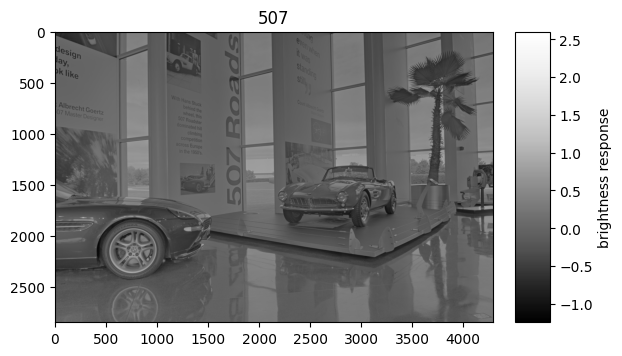

training/brightnesses/CadikDesk.npy already exists


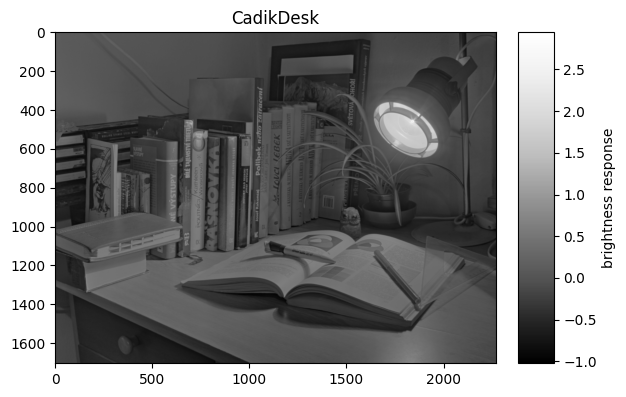

training/brightnesses/CadikNight.npy already exists


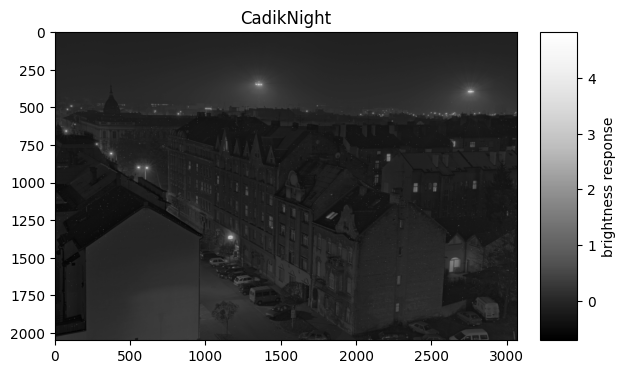

training/brightnesses/CadikWindow.npy already exists


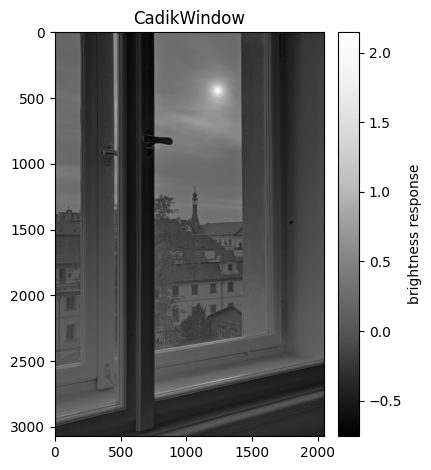

training/brightnesses/DelicateArch.npy already exists


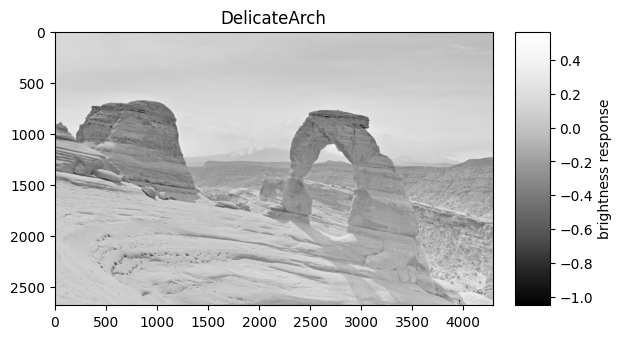

training/brightnesses/GeneralGrant.npy already exists


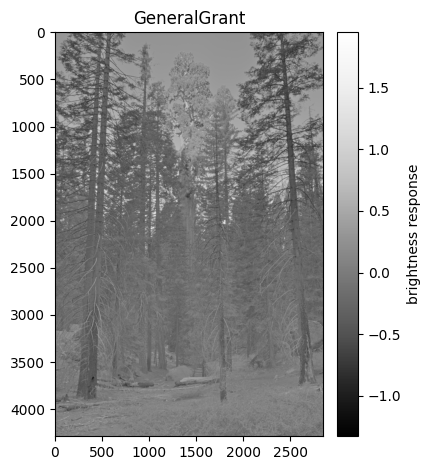

training/brightnesses/HDRMark.npy already exists


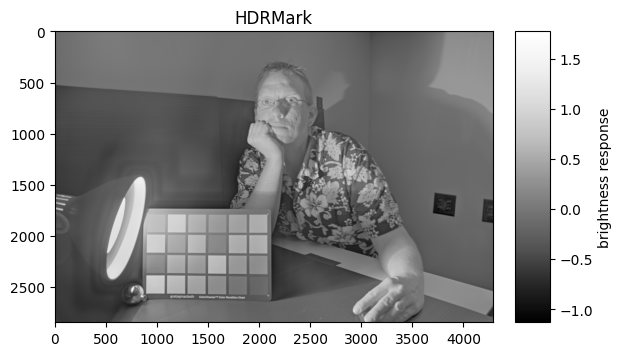

training/brightnesses/LuxoDoubleChecker.npy already exists


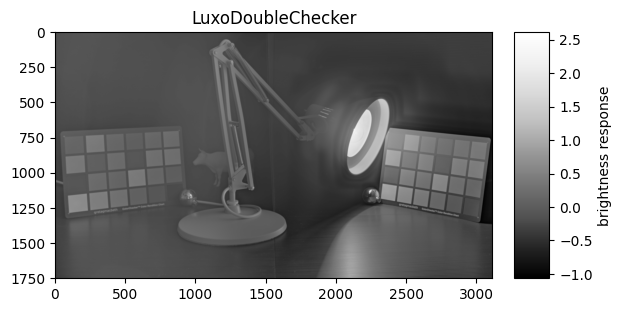

In [2]:
from pathlib import Path

import cv2
import numpy as np
from tqdm.auto import tqdm

from src import plotting


def file_to_brightness(file_path):
    image = dino.read_image(file_path)
    X, Y, Z = dino.rgb_to_xyz(image)
    L, _, _ = dino.xyz_to_lxy(X, Y, Z)
    return dino.dn_brightness_model(
        L,
        w=ACESModel.W,
        a=ACESModel.A,
        b=ACESModel.B,
        c=ACESModel.C,
        d=ACESModel.D,
        scale_normalized_constants=ACESModel.SCALE_NORMALIZED,
    )


# Generate brightness response images for all inputs
data_dir = Path("training")
for file in tqdm(list((data_dir / "images").iterdir()), desc="generating training set"):
    export_path = str(data_dir / "brightnesses" / file.stem) + ".npy"
    if Path(export_path).exists():
        print(f"{export_path} already exists")
        brightness = np.load(export_path)
    else:
        brightness = file_to_brightness(str(file))
        print(f"Exporting {export_path}")
        np.save(export_path, brightness)
    # Visualize brightness response
    plotting.image_pseudocolor_plot(brightness, title=file.stem, cmap="Grays_r", display=True)

In [3]:
class BrightnessDataset(torch.utils.data.Dataset):

    def __init__(self, input_dir, target_dir, max_width=1000, transform=None, target_transform=None):
        self.input_file_paths = sorted(f for f in Path(input_dir).iterdir() if f.is_file())
        self.target_file_paths = sorted(f for f in Path(target_dir).iterdir() if f.is_file())

        assert all(
            self.input_file_paths[i].stem == self.target_file_paths[i].stem
            for i in range(len(self.input_file_paths))
        )

        self.max_width = max_width
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.input_file_paths)

    def __getitem__(self, idx):
        input_image = dino.read_image(str(self.input_file_paths[idx]))
        input_image = dino.resize_image(
            input_image, resize_width=self.max_width
        )
        if self.transform:
            input_image = self.transform(input_image)
            
        brightness_response = np.load(self.target_file_paths[idx])
        brightness_response = dino.resize_image(
            brightness_response, resize_width=self.max_width
        )
        if self.target_transform:
            brightness_response = self.target_transform(brightness_response)

        return input_image, brightness_response


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device is {device}")
model = ACESModel().to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

train_set = BrightnessDataset("training/images", "training/brightnesses")
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True)

Device is cpu


In [ ]:
CHECKPOINT_PATH = Path("training/checkpoints")

def checkpoint_file_path(epoch):
    return str(CHECKPOINT_PATH / f"aces-epoch{epoch}.pickle")

start_epoch = 0
if start_epoch == 0:
    checkpoint = dict(
        state_dict={},
        train_losses=[],
        train_errors=[],
    )
else:
    checkpoint = torch.load(checkpoint_file_path(start_epoch), weights_only=False)
    model.load_state_dict(checkpoint["state_dict"])
    print(f"Loaded model from checkpoint at epoch {start_epoch}.")

e = start_epoch

In [ ]:
import matplotlib.pyplot as plt


max_epochs = 500

while e < max_epochs:
    train_losses = []
    for sample, brightness in tqdm(train_loader, desc=f"Epoch {e}"):
        sample = sample.to(device)
        brightness = brightness.float().to(device)
        prediction = model(sample)
        loss = loss_fn(prediction, brightness)
        train_losses.append(loss.detach().cpu().item())
        optim.zero_grad()
        loss.backward()
        optim.step()

        # CMAP = "viridis"
        # fig, axs = plt.subplots(1,2,figsize=(12,6))
        # target = np.squeeze(brightness.detach().cpu().numpy())
        # pred = np.squeeze(prediction.detach().cpu().numpy())
        # vmin = np.min(pred)
        # vmax = np.max(pred)
        # im = axs[0].imshow(target, vmin=vmin, vmax=vmax, cmap=CMAP)
        # axs[0].set_title("Original Brightness")
        # axs[1].imshow(pred, vmin=vmin, vmax=vmax, cmap=CMAP)
        # axs[1].set_title("ACES Brightness")
        # fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

    checkpoint["state_dict"] = model.state_dict()
    checkpoint["train_losses"].append(np.mean(train_losses))
    checkpoint["train_errors"].append([np.min(train_losses), np.max(train_losses)])
    torch.save(checkpoint, checkpoint_file_path(e))
    print(f"Average training loss: {checkpoint["train_losses"][-1]}")
    e += 1

In [ ]:
x_range = list(range(len(checkpoint["train_losses"])))
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.set_xlabel("Epochs")
ax.set_ylabel("Training loss (MSE)")
ax.fill_between(
    x_range,
    [y2 for _, y2 in checkpoint["train_errors"]],
    y2=[y1 for y1, _ in checkpoint["train_errors"]],
    color="grey",
    label="min-max",
    alpha=0.7,
)
ax.plot(x_range, checkpoint["train_losses"], "k-", label="avg")
_ = ax.legend()

print(model.weights.detach().cpu().numpy())

In [ ]:
# Compare learning to "canonical" ACES coefficients from
# https://knarkowicz.wordpress.com/2016/01/06/aces-filmic-tone-mapping-curve/
params = ["a", "b", "c", "d", "e"]
canonical_values = dict(zip(params, [2.51, 0.03, 2.43, 0.59, 0.14]))

learned_params = {p: [] for p in params}
num_epochs = 500
x_values = []
for epoch in range(num_epochs):
    epoch_file_path = checkpoint_file_path(epoch)
    if not Path(epoch_file_path).is_file():
        continue
    model.load_state_dict(torch.load(epoch_file_path, weights_only=False)["state_dict"])
    for p, value in zip(params, model.weights.detach().cpu().numpy(), strict=True):
        learned_params[p].append(value)
    x_values.append(epoch)
    
for param, learned_values in learned_params.items():
    fig, ax = plt.subplots()
    ax.set_xlabel("Epochs")
    ax.set_ylabel(f"Value of parameter {param}")
    ax.plot(x_values, learned_values, "b-", label="learned values")
    ax.plot(x_values, [canonical_values[param] for _ in x_values], "k--", label="canonical value")
    ax.legend()

In [ ]:
epoch_to_use = 430
model.load_state_dict(torch.load(checkpoint_file_path(epoch_to_use), weights_only=False)["state_dict"])

x_range = np.logspace(-2, 2, num=100, base=10)
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.set_xlabel("Input value")
ax.set_xscale("log")
ax.set_ylabel("ACES mapping")
ax.plot(x_range, aces(x_range, *model.weights.detach().cpu().numpy(), key=None), "b-", label="learned")
ax.plot(x_range, aces(x_range, *list(canonical_values.values()), key=None), "k--", label="canonical")
ax.legend()

In [ ]:
# # Canonical
a = 2.51
b = 0.03
c = 2.43
d = 0.59
e = 0.14

# # Learned
# a = 0.10450471
# b = 0.06196932
# c = 0.07076844
# d = 2.9122088
# e = 0.9020571

for file in (data_dir / "images").iterdir():
    if not file.suffix in [".hdr", ".exr"]:
        continue
    image = dino.read_image(str(file))
    tonemapped = aces(image, a, b, c, d, e)
    output_path = str(data_dir / "tonemapped" / f"{file.stem}_aces_a={a}_b={b}_c={c}_d={d}_e={e}.png")
    dino.write_image(output_path, tonemapped)
    print(f"Saved {output_path}")